# Housekeeping

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick

# Getting Data and Calculating MACD/Bollinger Bands

In [17]:
TICKER = 'SPY'

MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

BB_LEN = 20
DEVS = 2
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):

    # get data at interval you want
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df


def add_bollinger_bands(df, devs=DEVS, bb_len=BB_LEN):

    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df


# Creating and Testing Strategy

In [ ]:
def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    
    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure(figsize=(14, 7))
    plt.plot(df['Asset_Returns'],label=f'{TICKER} Buy & Hold', color='blue', linewidth=1.5)
    plt.plot(df['Strategy_Returns'], color='orange',linestyle='--', linewidth=1.5)
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    return df


# Summarising Returns and Running the Code 

C:\Users\EWD\AppData\Local\Temp\ipykernel_18512\2244357609.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed


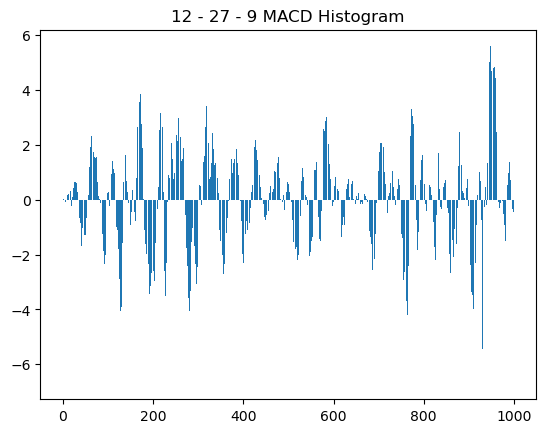

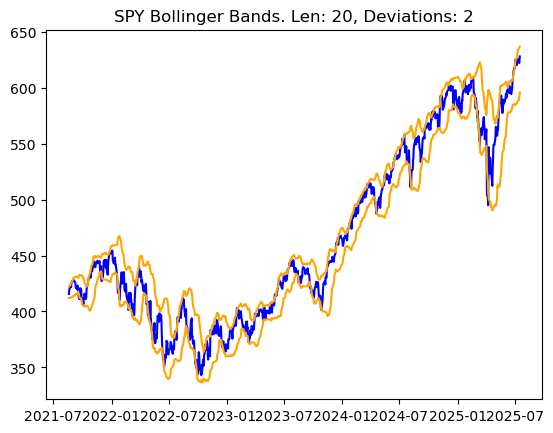

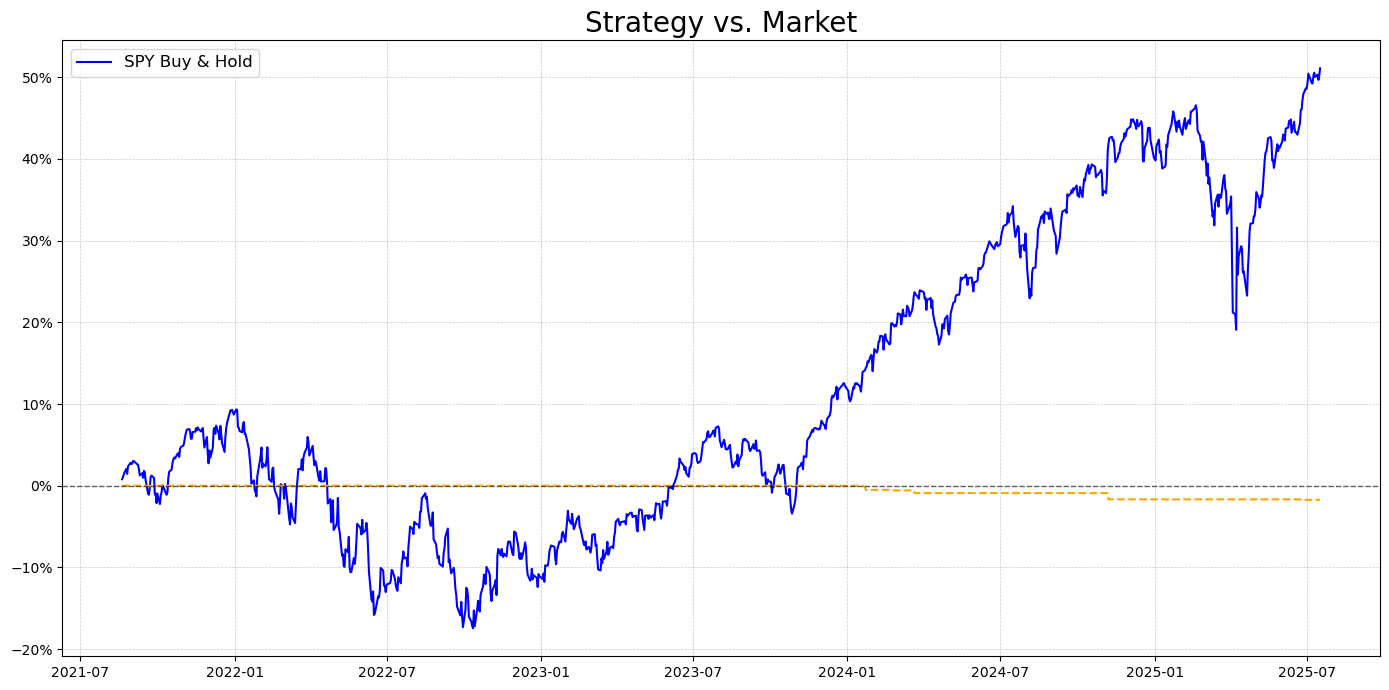

SPY Buy & Hold Return: 51.09%
SPY Bollinger Bands Strategy Return: -1.72%


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,BB_SMA,BB_STD,Upper_Band,Lower_Band,MACD_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,,,,,,,,
2021-08-19,415.661804,416.871415,412.127563,412.269306,92812200,418.014703,417.698767,0.315936,0.532487,-0.216552,417.192738,2.495100,422.182939,412.202538,NaN,NaN,NaN,0,NaN,NaN
2021-08-20,418.969360,419.300112,415.520164,416.011576,72008700,418.166108,417.813783,0.352325,0.496120,-0.143794,417.354335,2.500538,422.355412,412.353258,-1.0,0.0,-1.0,0,0.007957,0.00000
2021-08-23,422.654785,423.571423,419.044929,420.670307,54973000,418.874631,418.243788,0.630843,0.523265,0.107579,417.649173,2.760642,423.170457,412.127889,-1.0,0.0,-1.0,0,0.016824,0.00000
2021-08-24,423.325714,423.864363,422.805983,423.325714,38744700,419.574420,418.687474,0.886946,0.596433,0.290513,418.072528,2.952724,423.977977,412.167079,1.0,0.0,1.0,0,0.018438,0.00000
2021-08-25,424.214020,424.733751,423.136721,423.514739,40529700,420.301397,419.162437,1.138959,0.705453,0.433506,418.548802,3.140423,424.829647,412.267957,1.0,0.0,1.0,0,0.020575,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-11,623.619995,624.859985,621.530029,622.739990,63670200,618.321665,608.116078,10.205587,9.922016,0.283572,611.024109,11.381472,633.787052,588.261165,1.0,0.0,1.0,0,0.500306,-0.01721
2025-07-14,624.809998,625.159973,621.799988,623.159973,51898500,619.319870,609.308501,10.011370,9.939886,0.071483,612.166089,11.569512,635.305114,589.027064,1.0,0.0,1.0,0,0.503169,-0.01721
2025-07-15,622.140015,627.859985,622.059998,627.520020,74317300,619.753739,610.225038,9.528701,9.857649,-0.328948,613.511075,11.050210,635.611495,591.410655,1.0,0.0,1.0,0,0.496746,-0.01721


In [18]:
def return_summary(df, TICKER, LOOKBACK):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{TICKER} Bollinger Bands Strategy Return: {strategy_return:.2f}%")
    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_bollinger_bands(df)
    df = add_MACD_strategy(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER, LOOKBACK)  
    return df

main()